In [2]:
import csv
import requests
import json
import random
from random import shuffle
import pandas as pd
import progressbar
import os.path

import pyvips
import numpy as np
import  requests, json, os
import glob
import io
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import gc
import random

import tensorflow as tf

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:

random.seed(1367)


file_endpt = 'https://api.gdc.cancer.gov/files/%s?fields=file_id&expand=cases.diagnoses'

#download_dict = {}
max_files = 10

tumor_files = []

with open("tumor.txt") as f:
    first_row = True
    for row in csv.reader(f, delimiter='\t'):
        if first_row:
            first_row = False
            continue
        file_id = row[0]
        tumor_files.append(file_id)

shuffle(tumor_files)


normal_files = []
with open("normal.txt") as f:
    first_row = True
    for row in csv.reader(f, delimiter='\t'):
        if first_row:
            first_row = False
            continue
        file_id = row[0]
        normal_files.append(file_id)

shuffle(normal_files)



def download_file(url, path, cancer_type):
    r = requests.get(url, stream=True)
    path = cancer_type + "/"+ path
    if not os.path.isfile(path):
        with open(path, 'wb') as f:
            bar = progressbar.ProgressBar(prefix=path + "(%s)" % cancer_type)
            total_length = int(r.headers.get('content-length'))
            for chunk in bar(r.iter_content(chunk_size=1024), max_value=(total_length/1024) + 1): 
                if chunk:
                    f.write(chunk)
                    f.flush()
    else:
        print("file %s already exists... skipping." % path)

        
def download_files(label, file_list, max_files):
    for file_id in file_list[:max_files]:
        try:
            if not os.path.exists(label + "/" + file_id):
                download_file('https://api.gdc.cancer.gov/data/' + file_id, file_id+ ".tar.gz", label)
            else:
                print("File %s exists. Skip download", file_id)
        except Exception as ex:
            print("Something went wrong", ex)


download_files("tumor", tumor_files, 50)
download_files("normal", normal_files, 50)


file tumor/a7bc2c57-4813-4e59-9f5e-66adb169a757.tar.gz already exists... skipping.
file tumor/4aa93959-8111-4d2d-a000-06e34e500126.tar.gz already exists... skipping.
file tumor/98c29ab9-614b-431b-abeb-962a27602151.tar.gz already exists... skipping.
file tumor/0a5f5d19-45f1-4aed-944b-996d16551037.tar.gz already exists... skipping.
file tumor/c8dae94a-9772-419a-b498-9c2410a75c64.tar.gz already exists... skipping.
file tumor/315a0eaf-afaf-4b72-b585-af5d30a1e98e.tar.gz already exists... skipping.
file tumor/64fb60e0-e1b4-4c41-9cfb-3f71a4a29f6b.tar.gz already exists... skipping.
file tumor/7d28356e-b9ba-4dd2-a7ac-39cf6a4d3546.tar.gz already exists... skipping.
file tumor/600028fb-d431-47ac-9131-12d266a14afc.tar.gz already exists... skipping.
file tumor/4c09144a-4cf0-47da-a28c-3892262e54a2.tar.gz already exists... skipping.
file tumor/592af5eb-80ce-459e-b93a-272e027ea109.tar.gz already exists... skipping.
file tumor/2c5b6dba-0514-4412-bdd1-53ac19e23851.tar.gz already exists... skipping.
file

file normal/3978c76c-b79a-4ff2-8462-1d4ba672e50d.tar.gz already exists... skipping.


In [3]:


random.seed(1)

Image.MAX_IMAGE_PIXELS = 1000000000000000
Image.warnings.simplefilter('error', Image.DecompressionBombWarning)


tumor_files = glob.glob("tumor/*-*-*-*-*.tar.gz")
normal_files = glob.glob("normal/*-*-*-*-*.tar.gz")

def write_patch_vips(out_dir, image, fname, max_per_image, size):
    width = int(image.width)
    height = int(image.height)
    num_x_patches = min(int(width / size), max_per_image)
    num_y_patches = min(int(height/ size), max_per_image)
    print("Generating for %s ..."%(fname))
    file_name = os.path.basename(fname)
    
    for patch_x in range(0,num_x_patches):
        for patch_y in range(0, num_y_patches):            
            tile = image.crop(patch_x * size, patch_y * size, size, size)
            mem_img = tile.write_to_memory()
            img = Image.fromarray(np.frombuffer(mem_img, dtype=np.uint8).reshape(tile.width, tile.height, 4))
            background = Image.new("RGB", (size, size), (255, 255, 255))
            background.paste(img, mask=img.split()[3]) # 3 is the alpha channel
            ret2, otso = cv2.threshold(cv2.cvtColor(np.asarray(background), cv2.COLOR_BGR2GRAY),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            if ret2 < 150:
                # only sample 10% of the data
                coin = random.randint(1,10)
                if coin == 1:
                    tile.jpegsave(os.path.join(out_dir, file_name[:-5]) + '%d_%d' % (patch_x, patch_y) + '.jpg')

                    
                    
def patchify(files, prefix, max_process):
    prefix = output_dir +"/"+ prefix
    for file in files:
        if not os.path.exists(prefix):
            os.mkdir(prefix)
        try:
            if len(glob.glob(prefix+file[5:-7] + "*")) > 5:
                print("File %s seems to be processed... Skipping." % file)
            else:
                img = pyvips.Image.new_from_file(file, access='sequential')
                write_patch_vips(prefix, img, file, 100, 256)
        except Exception as ex:
            print(ex)
            print("Skipping %s" % file)


output_dir = "tumor_normal_patch/data"
        
patchify(tumor_files[0:10], "tumor", 50)
patchify(normal_files[0:10], "normal", 50)


File tumor/2c5b6dba-0514-4412-bdd1-53ac19e23851.tar.gz seems to be processed... Skipping.
File tumor/98c29ab9-614b-431b-abeb-962a27602151.tar.gz seems to be processed... Skipping.
File tumor/c1df5005-9bd8-42a6-92e4-d9d30b854dfe.tar.gz seems to be processed... Skipping.
File tumor/8627c5cb-aa4c-4e93-a8f6-8693bfca6f8c.tar.gz seems to be processed... Skipping.
File tumor/fa714b76-96bb-4f46-9326-1f4a84bdef9c.tar.gz seems to be processed... Skipping.
File tumor/96c0d7dd-0a77-4317-b670-6caf340c1b9d.tar.gz seems to be processed... Skipping.
File tumor/04de8f2d-6b86-43b7-8f04-101107041832.tar.gz seems to be processed... Skipping.
File tumor/994981dc-531d-4a37-8106-327a1f5baa12.tar.gz seems to be processed... Skipping.
File tumor/6fb14107-48c9-4b9f-9992-ae2ba2672fed.tar.gz seems to be processed... Skipping.
File tumor/3e19ec4c-50b1-41f4-9b25-17862bdcf73d.tar.gz seems to be processed... Skipping.
Generating for normal/b1183b7d-6939-47b6-a57c-166f14603fb9.tar.gz ...


KeyboardInterrupt: 

In [4]:
output_dir = "tumor_normal_patch/data/"
path = "tumor_normal_patch/data/"

def adjust_image(im):
    imgs = im.resize((299, 299), Image.ANTIALIAS)
    return imgs

X=[]
Y=[]

classes = {}

for directory in os.listdir(output_dir):
    for file in os.listdir(path + directory)[:2000]:
        #converted_file = converted_files + file[:-4] + "_fake_B.png"        
#        if(os.path.exists(converted_file)):
            img=Image.open(path + directory + "/" + file).convert("RGB")
            img=adjust_image(img)
            features=np.array(img, dtype=np.float32)/255.0
#           processed_img = Image.open(converted_file)
            #processed_feature=np.array(processed_img, dtype=np.float32)/255.0
            #X_processed.append(processed_feature)
            X.append(features)
            if directory in classes:
                class_id = classes[directory]
            else:
                class_id = len(classes.keys())
                classes[directory] = class_id
            Y.append(class_id)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
#X_processed_train, X_processed_test, y_processed_train, y_processed_test = train_test_split(X_processed, Y, test_size=0.33, random_state=42)

#X_processed_train = np.array(X_processed_train)
#X_processed_test = np.array(X_processed_test)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [5]:
y_train.shape

(2680,)

1


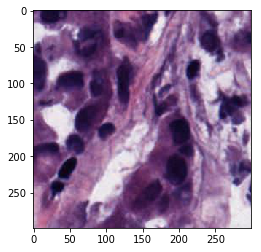

In [6]:
print(y_test[1])
plt.imshow(X_test[1])

0


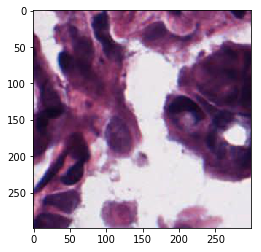

In [8]:
print(y_test[5])
plt.imshow(X_test[10])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'breast_tn_conv_new', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3144397b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-04-05:20:01
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from breast_tn_conv_new/model.ckpt-11736
INFO:tensorflow:Running local_init_op.
INFO:tenso

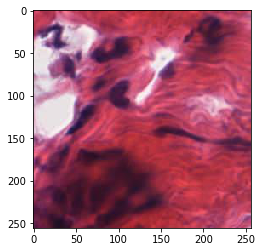

In [6]:
im = plt.imread("/home/amir/project/tumor_normal_patch/normal/976307af-061c-475c-8772-ac0c5851b4a2.t86_30.jpg")
plt.imshow(im)

In [9]:
import tensorflow_hub as hub
NUM_CLASSES = 2

def inceptionv3_model_fn(features, labels, mode):
    # Load Inception-v3 model.
    module = hub.Module("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1")
    input_layer = features["x"]
    outputs = module(input_layer)
    logits = tf.layers.dense(inputs=outputs, units=NUM_CLASSES)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    accuracy = tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])
    tf.summary.scalar("accuracy", accuracy[1])
    
    

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Set up logging for predictions
    tensors_to_log = {"accuracy": accuracy[1]}
    logging_hook = tf.train.LoggingTensorHook(
        tensors=tensors_to_log, every_n_iter=100)
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op, training_hooks=[logging_hook])

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": accuracy}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)



def run_graph(X_train_, y_train_, X_test_, y_test_, log_dir, epochs):
    with tf.Graph().as_default() as g:
            # create input functions for train and evaluate methods.
            train_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": X_train_},
                y=y_train_,
                batch_size=40,
                num_epochs=None,
                shuffle=True)
            eval_input_fn = tf.estimator.inputs.numpy_input_fn(
                x={"x": X_test_},
                y=y_test_,
                num_epochs=1,
                shuffle=False)

            # Create an estimator
            classifier = tf.estimator.Estimator(
                model_fn=inceptionv3_model_fn, model_dir=log_dir)
            
            for i in range(epochs):
                print("Epoc %i..." % i)
                # Train network.
                classifier.train(
                    input_fn=train_input_fn,
                    steps=200)

                # Evaluate the model and print results.
                eval_results = classifier.evaluate(input_fn=eval_input_fn)

run_graph(X_train, y_train, X_test, y_test, "breast_tn_classification", 50)
#run_graph(X_processed_train, y_train, X_processed_test, y_test, "lung_classification_processed", 25)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'breast_tn_classification', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1511f8fc18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Epoc 0...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_1a_3x3/BatchNorm/beta
INFO:tensorflow:Initializ

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_1a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b0

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_1a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_1a_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_2a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_2a_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b0

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0e_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-07-06:35:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from 

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b0

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0d_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0d_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_4a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_4a_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixe

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_2b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_2b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0c_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0c_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0c_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_1a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_1a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_1a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_1a_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_2a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_2a_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-07-06:39:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from 

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b0

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0d_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0d_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b0

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_1a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b0

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_1a_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_1a_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_2a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_2a_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_2a_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b0

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0c_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0d_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0e_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0b_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0b_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_0/Conv2d_1a_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0b_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-07-06:44:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from breast_tn_classification/model.ckpt-1200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-07-06:44:40
INFO:tensorflow:Saving dict for global step 1200: accuracy = 0.51969695, global_step = 1200, loss 

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_1/Conv2d_0b_5x5/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv_1_0c_5x5/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0d_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0d_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0d_3x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0c_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0d_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b0

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_0/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_1/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_1/Conv2d_0b_5x5/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b0

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0c_1x7/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0c_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_1a_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0c_1x3/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_2/Conv2d_0b_3x3/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Conv2d_3b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Conv2d_3b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5b/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b0

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_5d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_0/Conv2d_1a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6b/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6b/Branch_2/Conv2d_0b_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6c/Branch_3/Conv2d_0b_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_0/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6d/Branch_2/Conv2d_0d_7x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6d/Branch_2/Conv2d_0e_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_6e/Branch_2/Conv2d_0b_7x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7a/Branch_1/Conv2d_0b_1x7/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/va

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7b/Branch_2/Conv2d_0a_1x1/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7b/Branch_2/Conv2d_0b_3x3/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff4215

INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/weights:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0b_1x3/weights
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/beta:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/beta
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variables/variables' with InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable module/InceptionV3/Mixed_7c/Branch_1/Conv2d_0c_3x1/BatchNorm/moving_variance:0 from checkpoint b'/tmp/tfhub_modules/11d9faf945d073033780fd924b2b09ff42155763/variab

KeyboardInterrupt: 